<a href="https://colab.research.google.com/github/SeshaSaiVeerla/Diabetes-Prediction-A-Multifaceted-Machine-Learning-Approach/blob/main/Part_2_Transformer_GPT2_Ilocano_Translator_New_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


!pip install transformers
!pip install datasets
!pip install nltk
!pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 5.6 MB/s eta 0:00:00


In [4]:
import re
import json
import torch
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from nltk.translate.bleu_score import corpus_bleu
from collections import Counter
import sacrebleu
#from nltk.translate.chrf_score
import warnings
warnings.filterwarnings("ignore")

In [5]:

with open('/content/Ilocano.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
print(f"Dataset loaded with {len(data)} entries.")

# Extract and align English and Chichewa sentences
en_sentences = [entry['input'] for entry in data[:4000]]
ic_sentences = [entry['output'] for entry in data[:4000]]



Dataset loaded with 66358 entries.


In [6]:
print("Initializing tokenizer...")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'additional_special_tokens': ["<|sep|>"]})
tokenizer.pad_token = tokenizer.eos_token
tokenizer_func = lambda x: x.split()

def build_vocab(sentences):
    print(f"Building vocabulary for {len(sentences)} sentences...")
    counter = Counter()
    for sentence in sentences:
        counter.update(tokenizer_func(sentence))
    return counter

en_vocab = build_vocab(en_sentences)
ch_vocab = build_vocab(ic_sentences)

# Adding special tokens to vocabulary
print("Adding special tokens to vocabulary...")
en_vocab = {'<s>': 1, '</s>': 2, '<pad>': 0, '<unk>': 3, **en_vocab}
ch_vocab = {'<s>': 1, '</s>': 2, '<pad>': 0, '<unk>': 3, **ch_vocab}

def sentence_to_tensor(sentence, vocab, max_len=128):
    tokens = tokenizer_func(sentence)
    indices = [vocab.get(token, vocab['<unk>']) for token in tokens]
    indices = [vocab['<s>']] + indices + [vocab['</s>']]
    if len(indices) < max_len:
        indices += [vocab['<pad>']] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return torch.tensor(indices)

Initializing tokenizer...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Building vocabulary for 4000 sentences...
Building vocabulary for 4000 sentences...
Adding special tokens to vocabulary...


In [7]:

def encode_translation_pairs(inputs, outputs, tokenizer, max_len=128):
    print(f"Encoding {len(inputs)} translation pairs...")
    translations = [
        f"{inputs[i]} <|sep|> {outputs[i]}"
        for i in range(len(inputs))
    ]
    return tokenizer(
        translations,
        max_length=max_len,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )["input_ids"]

encoded_data = encode_translation_pairs(en_sentences, ic_sentences, tokenizer)
dataset = Dataset.from_dict({"input_ids": encoded_data, "labels": encoded_data})
train_size = int(0.75 * len(dataset))
val_size = (len(dataset) - train_size) // 2
train_dataset, temp_dataset = dataset.train_test_split(train_size=train_size).values()
val_dataset, test_dataset = temp_dataset.train_test_split(train_size=val_size).values()

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Encoding 4000 translation pairs...
Train dataset size: 3000
Validation dataset size: 500
Test dataset size: 500


In [8]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50258, 768)

In [9]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to=[]
)


In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,3.187700,3.083122
2,2.781800,2.873038
3,2.346800,2.776137
4,2.155000,2.735858
5,1.962500,2.728109
6,1.920300,2.723968
7,1.781100,2.757471
8,1.472500,2.795436
9,1.482600,2.828169
10,1.315700,2.871802


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=5625, training_loss=1.8222172247144912, metrics={'train_runtime': 321.9101, 'train_samples_per_second': 139.791, 'train_steps_per_second': 17.474, 'total_flos': 2939535360000000.0, 'train_loss': 1.8222172247144912, 'epoch': 15.0})

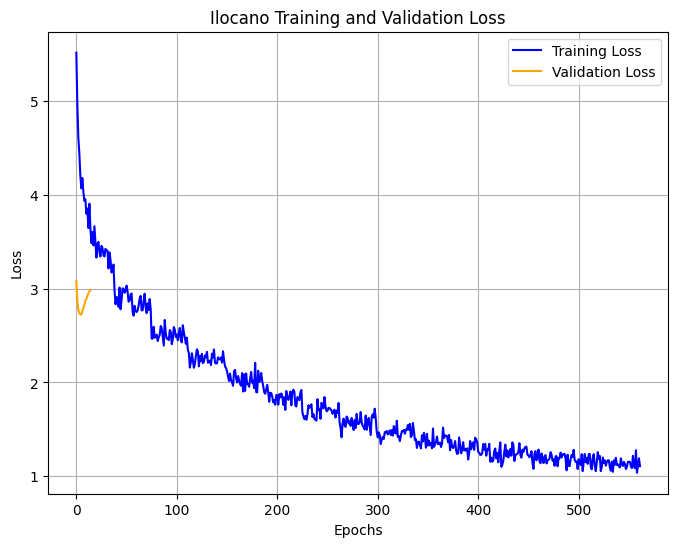

In [11]:
import matplotlib.pyplot as plt

def plot_training_and_validation_loss(log_history):
    training_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
    validation_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]

    plt.figure(figsize=(8, 6))
    plt.plot(range(len(training_loss)), training_loss, label="Training Loss", color='blue')
    plt.plot(range(len(validation_loss)), validation_loss, label="Validation Loss", color='orange')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Ilocano Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training_and_validation_loss(trainer.state.log_history)


In [12]:
import torch
import re

def translate_sentence(model, tokenizer, sentence, device):
    inputs = tokenizer.encode(sentence, return_tensors="pt", max_length=128, truncation=True, padding=True)
    inputs = inputs.to(device)
    attention_mask = (inputs != tokenizer.pad_token_id).long().to(device)

    with torch.no_grad():
        outputs = model.generate(inputs, attention_mask=attention_mask, max_length=128, num_beams=4, early_stopping=True)

    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Remove any leading punctuation
    match = re.search(r'[.?!]', translated_text)
    if match:
        translated_text = translated_text[match.end():].strip()

    return translated_text

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Updated set of sentences for translation
sentences_to_translate = [
    "What is your favorite dish?",
    "Can you recommend a good restaurant?",
    "I love watching the sunset at the beach.",
    "Let's plan a trip for the summer.",
    "Do you have any hobbies?",
    "How was your weekend?",
    "I need to buy groceries later.",
    "What kind of music do you enjoy?",
    "Have you traveled abroad before?",
    "What are your plans for the holidays?"
]

# Translating and displaying the sentences
print("\nTranslating sentences:")
for sentence in sentences_to_translate:
    translation = translate_sentence(model, tokenizer, sentence, device)
    print(f"English: {sentence}")
    print(f"Ilocano: {translation}\n")  # Adds an empty line between sentences

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Translating sentences:


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


English: What is your favorite dish?
Ilocano: ania a kita ti mamagbalin a dumakdakkel a kita ti mamagbalin a dumakdakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a dumakkel a



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


English: Can you recommend a good restaurant?
Ilocano: maibatay iti nasayaat nga estudiante iti nasayaat nga estudiante iti nasayaat nga estudiante iti nasayaat nga estudiante iti nasayaat nga estudiante iti nasayaat nga estudiante iti nasayaat nga estudiante iti nasayaat nga estudiante iti nasayaat nga estudiante iti nasayaat nga estudiante iti nasayaat



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


English: I love watching the sunset at the beach.
Ilocano: nakakatkatawa ti panagbalbaliw iti tiendaan nga aramid iti tiendaan nga aramid iti tiendaan nga aramid iti tiendaan nga aramid iti tiendaan nga aramid iti tiendaan nga aramid iti tiendaan nga aramid iti tiendaan nga aramid iti tiendaan nga aramid iti tiendaan nga aramid iti tiendaan



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


English: Let's plan a trip for the summer.
Ilocano: mapasamak iti sumagmamano para iti panangusar kadagiti sumagmamano kadagiti sumagmamano kadagiti sumagmamano kadagiti sumagmamano kadagiti sumagmamano kadagiti sumagmamano kadagiti sumagmamano kadagiti sumagmamano kadagiti sumagmamano kadagiti sumagmamano kadagiti sumagmamano



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


English: Do you have any hobbies?
Ilocano: mabalinmo nga aramidenmo kadagiti tattao nga aramidenmo kadagiti tattao nga aramidenmo kadagiti tattao nga aramidenmo kadagiti tattao nga aramidenmo kadagiti tattao nga aramidenmo kadagiti tattao nga aramidenmo kadagiti tattao nga aramidenmo kadagiti tattao nga aramidenmo kadagiti tattao nga aramidenmo kad



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


English: How was your weekend?
Ilocano: ania ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti maysa a kasasaad ti m



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


English: I need to buy groceries later.
Ilocano: kasasaad ti panangusar kadagiti sumagmamano a gumatang iti bagim ti panangusar kadagiti bagim ti panangusar kadagiti bagim ti panangusar kadagiti bagim ti panangusar kadagiti bagim ti panangusar kadagiti bagim ti panangusar kadagiti bagim ti panangusar kadagiti bagim ti panangusar kadagiti bagim ti panangusar



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


English: What kind of music do you enjoy?
Ilocano: ania a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a kita ti libro a k



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


English: Have you traveled abroad before?
Ilocano: nagsuratko iti maysa nga aldaw ti panangusar iti maysa nga aldaw ti panangusar iti maysa nga aldaw ti maysa nga aldaw ti maysa nga aldaw ti maysa nga aldaw ti maysa nga aldaw ti maysa nga aldaw ti maysa nga aldaw ti maysa nga aldaw ti maysa nga aldaw ti maysa

English: What are your plans for the holidays?
Ilocano: ania dagiti plano para iti pakagupgopan kadagiti pagimbagan ti panangusar kadagiti pagimbagan ti panangusar kadagiti pagimbagan ti panangusar kadagiti pagimbagan ti panangusar kadagiti pagimbagan ti panangusar kadagiti pagimbagan ti panangusar kadagiti pagimbagan ti panangusar kadagiti pagimbagan ti panangusar kadagiti pagimb

